## Projet 4 : Construisez un modèle de scoring

## Contexte

Une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin qule e modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un clienée

Notre objectif développer cet algorithme de classificationns.

## Librairies utilisées avec le langage Python:

In [202]:
# Importation des librairies
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC # svC car problème de classification (sinon SVR pour la regression)
from sklearn.model_selection import  GridSearchCV, cross_validate, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import  metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,fbeta_score,roc_auc_score,confusion_matrix,precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, make_scorer
import os

import warnings
warnings.filterwarnings('ignore')

## Données brutes:

Nous avons 4 fichiers CSV :
- X_train : dataframe d'entrainement
- X_test : dataframe de test
- y_train : array de la variable cible pour le dataframe d'entrainement
- y_test : array de la variable cible pour le dataframe de test


In [203]:
# Chargement des données brutes du fichier CSV
X_train = pd.read_csv('/tutorial-env/OCR/Projet 4/X_train.csv')
X_test = pd.read_csv('/tutorial-env/OCR/Projet 4/X_test.csv')
y_train = pd.read_csv('/tutorial-env/OCR/Projet 4/y_train.csv')
y_test = pd.read_csv('/tutorial-env/OCR/Projet 4/y_test.csv')


## Normalisation et équilibrage des données:

Afin que les différents ordres de grandeur des variables n'impactent pas les résultats des modèles, normalisons les données pour que chaque variable ait une moyenne égale à 0 et une variance égale à 1.

In [204]:
# Créer une instance de Standardscaler
scaler = StandardScaler()

# Normalisation des données (entrainement de l'imputer seulement sur les données d'entrainement pour éviter la fuite de données)
X_train_norm = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
    )
X_test_norm = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
    )

# Save the processed data
X_train_norm.to_csv('D:/tutorial-env/OCR/Projet 4/X_train_norm.csv', index=False)
X_test_norm.to_csv('D:/tutorial-env/OCR/Projet 4/X_test_norm.csv', index=False)

X_train_norm.describe(include="all")

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,...,EXT_SOURCE_2 EXT_SOURCE_3 AGE,EXT_SOURCE_2 AGE^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 AGE,EXT_SOURCE_3 AGE^2,AGE^3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
count,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,...,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05
mean,-1.740195e-17,-2.566247e-17,-1.001587e-16,6.598301e-17,3.396630e-17,-1.191998e-16,1.198930e-16,1.344139e-16,-1.502561e-16,-7.081187e-17,...,2.041155e-16,-3.093938e-16,-1.830166e-16,4.607908e-17,-5.362040e-16,-2.288249e-16,-2.544585e-17,2.618236e-17,4.396846e-16,8.224409e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.247234e-01,-7.181585e-01,-1.504877e+00,-5.788480e-01,-5.533760e-01,-1.374886e+00,-1.755635e+00,-1.334438e+00,-1.488335e+00,-7.174946e+00,...,-1.583469e+00,-1.498425e+00,-1.285525e+00,-1.474042e+00,-1.490044e+00,-1.236052e+00,-1.469247e+00,-1.910678e+00,-1.407703e+00,-1.229568e+00
25%,-3.247234e-01,-7.181585e-01,-1.504877e+00,-5.788480e-01,-2.177083e-01,-8.160175e-01,-7.296359e-01,-8.105069e-01,-7.856671e-01,-2.393255e-01,...,-7.856490e-01,-7.913814e-01,-7.778655e-01,-7.364646e-01,-7.992879e-01,-8.379680e-01,-7.211528e-01,-7.006335e-01,-7.465883e-01,-6.704507e-01
50%,-3.247234e-01,-7.181585e-01,6.645063e-01,-5.788480e-01,-8.726755e-02,-2.124392e-01,-1.513679e-01,-2.378382e-01,-1.460626e-01,2.833847e-01,...,-1.347512e-01,-2.144636e-01,-1.989178e-01,-1.525855e-01,-2.310782e-01,-3.044047e-01,-2.591908e-01,-1.918845e-01,-1.652879e-01,-2.576931e-01
75%,-3.247234e-01,1.392450e+00,6.645063e-01,8.093218e-01,1.301338e-01,5.219143e-01,5.168184e-01,3.835683e-01,5.636207e-01,6.184433e-01,...,6.481073e-01,6.342508e-01,5.403890e-01,5.418466e-01,6.217268e-01,6.868723e-01,4.461135e-01,5.076919e-01,4.598731e-01,3.388940e-01
max,3.079544e+00,1.392450e+00,6.645063e-01,2.579638e+01,4.515422e+02,8.572978e+00,1.399186e+01,9.509714e+00,3.734523e+00,1.053177e+00,...,4.465937e+00,3.695439e+00,3.811027e+00,4.266265e+00,3.987615e+00,2.938628e+00,3.005412e+01,1.793057e+01,3.145881e+00,4.697029e+00


Pour éliminer un biais dans l'apprentissage de nos modèles, ocupons-nous maintenant du rééquilibrage des données avec la méthode SMOTE (Synthetic Minority Oversampling Technique) qui va créer de nouveaux exemples de la classe minoritaires plausibles d'après les exemples actuels de la classe minoritaire.

In [205]:
y_train.shape

(246008, 1)

In [206]:
# Méthode SMOTE pour l'équilibrage des données
oversample = SMOTE()
X_train_eq, y_train_eq = oversample.fit_resample(X_train_norm, y_train)

Comparons la différence de distribution de notre variable cible avant et après la méthode SMOTE :

<Axes: title={'center': 'Distribution de la variable cible "TARGET" initial'}, xlabel='TARGET_x', ylabel='count'>

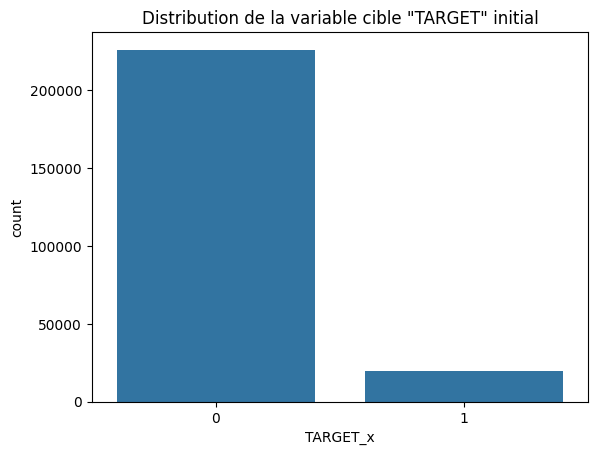

In [207]:
plt.title(f'Distribution de la variable cible "TARGET" initial')
sns.countplot(y_train, x="TARGET_x")

<Axes: title={'center': 'Distribution de la variable cible "TARGET"après SMOTE'}, xlabel='TARGET_x', ylabel='count'>

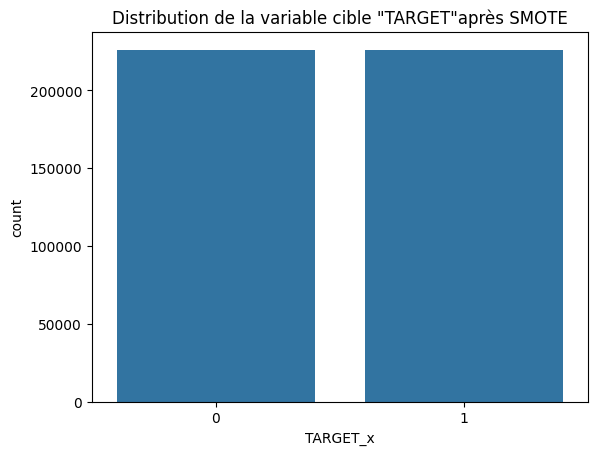

In [208]:
plt.title(f'Distribution de la variable cible "TARGET"après SMOTE')
sns.countplot(y_train_eq, x="TARGET_x")

In [209]:
y_train_eq.shape

(452248, 1)

Nos données d'entrainements sont bien équilibrées, cependant, le nombre de lignes de notre dataframe est significativment plus important et va induire des temps d'apprentissage et d'éxécution trop longs.

Testons donc une méthode qui qui supprimera des éléments de la classe majoritaire à la place avec la fonction RandomUnderSampler:


In [210]:
rus = RandomUnderSampler(random_state=42)
X_train_eq, y_train_eq = rus.fit_resample(X_train_norm, y_train)

<Axes: title={'center': 'Distribution de la variable cible "TARGET" après RandomUnderSampler'}, xlabel='TARGET_x', ylabel='count'>

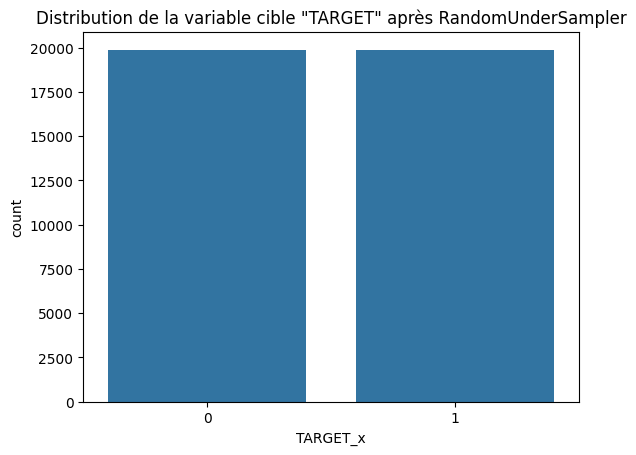

In [211]:
plt.title(f'Distribution de la variable cible "TARGET" après RandomUnderSampler')
sns.countplot(y_train_eq, x="TARGET_x")

In [212]:
y_train_eq.shape

(39768, 1)


 Nos données d'entrainements sont bien équilibrées et le nombre de lignes est beaucoup plus petite ce qui va nous permettre de pouvoir faire tourner nos algorithmes plus rapidement.

 Bien entendu, nous laissons les données de tests déséquilibrées puisqu'elles doivent refléter la réalité.

## Modélisation et évaluation:

Nous allons tester différents modèles de classification binaire et évaluer leur efficacité en terme de performances et de temps d'entainement et d'exécution.

Pour l'évaluation des performances nous allons calculer différentes métriques :
- l'accuracy (efficacité d'un modèle à prédire correctement à la fois les individus positifs et négatifs)
- la précision (nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit)
- le recall (nombre de positifs bien prédit (VP) divisé par l’ensemble des positifs)
- le F1 score (moyenne harmonique du recall et de la precision)
- le F beta score (avec beta>1, pour accorder plus d’importance au recall (autrement dit aux Faux Négatif) puisque la prédiction des difficultés de remboursement est plus importante pour l'entreprise. En effet, les FN coûtent plus d'argent que les Faux Positifs.)

### Modèle de base :

Notre modèle de base va effectuer des prédictions basées sur la valeur de la variable la plus fréquente.

In [213]:
#Entrainement du classifieur
clf = DummyClassifier(strategy=  "most_frequent",random_state=42).fit(X_train_eq,y_train_eq)

#Prédiction de la variable cible sur la base de données test
y_pred = clf.predict(X_test_norm)
y_pred_proba = clf.predict_proba(X_test_norm)[:, 1]

#Distribution de la variable cible sur la base de données test
print('y réel : \n' +  str(y_test.value_counts())+'\n')

#Distribution de la variable cible prédite
print('y prédit: \n' + str(pd.Series(y_pred).value_counts()))

y réel : 
TARGET_x
0           56562
1            4941
Name: count, dtype: int64

y prédit: 
0    61503
Name: count, dtype: int64


In [214]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred))) #si problème de régression, remplacé par R²
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('F beta Score (avec beta=2) : ' + str(fbeta_score(y_test,y_pred, beta=2)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.919662455489976
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
F beta Score (avec beta=2) : 0.0
Aire sous la courbe ROC : 0.5


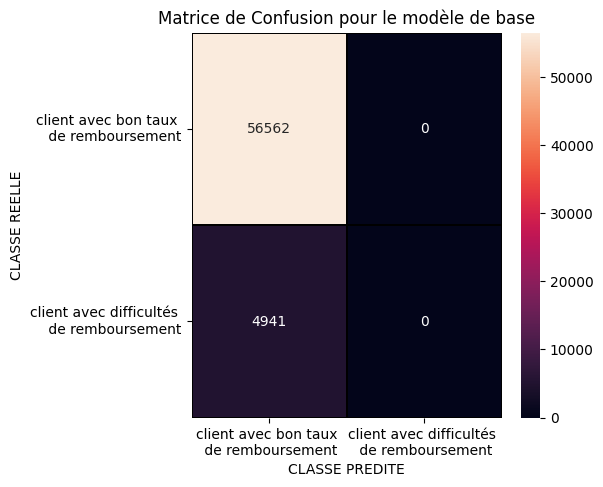

In [215]:
# Graphique de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le modèle de base')
plt.show()

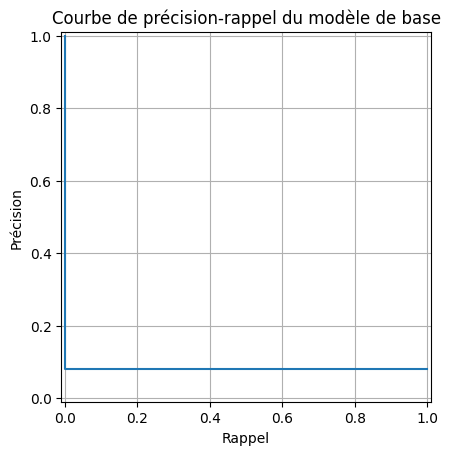

In [216]:
# Graphique précision-rappel
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du modèle de base')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du modèle de base')

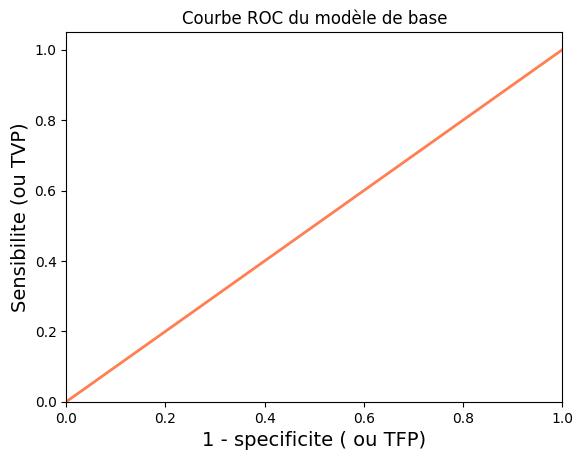

In [217]:
# Graphique courbe ROC
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du modèle de base')

Nous voyons que prédire la classe la plus représentée (ici 0) permet d'obtenir une bonne accuracy mais des résultats médiocres pour tous les autres scores.

De plus, il n'y a aucune minimisation des FN puisque toutes les prédictions sont égales à 0 donc avec un bon taux de remboursement. Or c'est ce que l'on souhaite obtenir !

### Modèles linéaires de régression logistique :

Le modèle de régression logistique est un modèle simple qui analyse les relations entre une variable cible binaire et l’ensemble des autres variables indépendantes. Cette relation est exprimée comme une équation qui prédit la probabilité de réalisation des deux classes de la variable cible comme une combinaison linéaire de paramètres suivant une fonction logistique.


In [218]:
# Création d'une instance de modèle de régression logistique
lr = LogisticRegression(solver="saga",max_iter=1000,n_jobs=-1,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train_eq,y_train_eq)
y_pred_lr = lr.predict(X_test_norm)
y_pred_lr_prob = lr.predict_proba(X_test_norm)[:, 1]


In [219]:
# score de la régression logistique
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_lr)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_lr)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_lr)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_lr)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_lr, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_lr)))

Accuracy Score : 0.6857063883062615
Precision Score : 0.15787721717628037
Recall Score : 0.6719287593604534
F1 Score : 0.25567963034270313
F beta Score (avec beta=3) : 0.5068857064337843
Aire sous la courbe ROC : 0.6794193494479153


In [220]:
lr = LogisticRegression(solver="saga", penalty='elasticnet',max_iter=200, n_jobs=-1,random_state=42)
params = {'C': np.logspace(-5, 5, 10),"l1_ratio": np.linspace(0, 1, 10)}

# optimisation des paramètres avec la grid search
grid_lr = GridSearchCV(lr, params,cv=3, n_jobs=-1)
grid_lr.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_lr_gs = grid_lr.best_estimator_

In [221]:
print(best_model_lr_gs)

LogisticRegression(C=0.021544346900318846, l1_ratio=1.0, max_iter=200,
                   n_jobs=-1, penalty='elasticnet', random_state=42,
                   solver='saga')


In [222]:
cvres_lr=pd.DataFrame(grid_lr.cv_results_)
cvres_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,14.295161,2.745839,0.053666,0.007820,0.00001,0.0,"{'C': 1e-05, 'l1_ratio': 0.0}",0.670112,0.676147,0.662643,0.669634,0.005523,80
1,1.630159,0.194525,0.089833,0.002267,0.00001,0.111111,"{'C': 1e-05, 'l1_ratio': 0.1111111111111111}",0.500000,0.500000,0.500000,0.500000,0.000000,88
2,1.528428,0.284983,0.109348,0.035330,0.00001,0.222222,"{'C': 1e-05, 'l1_ratio': 0.2222222222222222}",0.500000,0.500000,0.500000,0.500000,0.000000,88
3,0.748045,0.155430,0.063622,0.007552,0.00001,0.333333,"{'C': 1e-05, 'l1_ratio': 0.3333333333333333}",0.500000,0.500000,0.500000,0.500000,0.000000,88
4,0.867703,0.133214,0.079401,0.014607,0.00001,0.444444,"{'C': 1e-05, 'l1_ratio': 0.4444444444444444}",0.500000,0.500000,0.500000,0.500000,0.000000,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,113.469420,2.330913,0.085787,0.014051,100000.0,0.555556,"{'C': 100000.0, 'l1_ratio': 0.5555555555555556}",0.679617,0.684294,0.675543,0.679818,0.003575,30
96,114.781169,0.642133,0.072237,0.000813,100000.0,0.666667,"{'C': 100000.0, 'l1_ratio': 0.6666666666666666}",0.679617,0.684294,0.675543,0.679818,0.003575,30
97,114.879474,1.688460,0.061487,0.006926,100000.0,0.777778,"{'C': 100000.0, 'l1_ratio': 0.7777777777777777}",0.679617,0.684294,0.675543,0.679818,0.003575,30
98,107.196736,0.893378,0.050401,0.002635,100000.0,0.888889,"{'C': 100000.0, 'l1_ratio': 0.8888888888888888}",0.679617,0.684294,0.675543,0.679818,0.003575,30


In [223]:
cols= [i for i in cvres_lr.columns if "split" not in i ]
cvres_lr=cvres_lr [cols].sort_values("rank_test_score")
cvres_lr.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,mean_test_score,std_test_score,rank_test_score
39,98.312407,3.629885,0.073375,0.010357,0.021544,1.0,"{'C': 0.021544346900318846, 'l1_ratio': 1.0}",0.681704,0.003535,1
38,106.855780,2.557497,0.074327,0.004887,0.021544,0.888889,"{'C': 0.021544346900318846, 'l1_ratio': 0.8888...",0.681603,0.003424,2
21,77.484525,2.149557,0.060890,0.009166,0.001668,0.111111,"{'C': 0.0016681005372000592, 'l1_ratio': 0.111...",0.681578,0.003537,3
36,120.429213,3.650286,0.066316,0.004100,0.021544,0.666667,"{'C': 0.021544346900318846, 'l1_ratio': 0.6666...",0.681201,0.003906,4
37,108.747620,3.058590,0.078589,0.014779,0.021544,0.777778,"{'C': 0.021544346900318846, 'l1_ratio': 0.7777...",0.681151,0.003602,5
35,118.860508,2.981198,0.102486,0.031402,0.021544,0.555556,"{'C': 0.021544346900318846, 'l1_ratio': 0.5555...",0.680849,0.003690,6
34,110.223963,4.222926,0.083671,0.011836,0.021544,0.444444,"{'C': 0.021544346900318846, 'l1_ratio': 0.4444...",0.680597,0.003878,7
49,121.048396,5.862265,0.073260,0.003787,0.278256,1.0,"{'C': 0.2782559402207126, 'l1_ratio': 1.0}",0.680346,0.003678,8
48,103.903106,2.980781,0.092510,0.004824,0.278256,0.888889,"{'C': 0.2782559402207126, 'l1_ratio': 0.888888...",0.680271,0.003800,9
33,110.809668,10.827773,0.096196,0.032274,0.021544,0.333333,"{'C': 0.021544346900318846, 'l1_ratio': 0.3333...",0.680220,0.004133,10


Les hyperparamètres optimisés correspondent au couple {'C': 0.021544, 'l1_ratio': 1.0} et entrainent une maximisation  du mean_test_score égal à 0.681704.

Mais nous pouvons également remarquer que le troisième meilleur permet d'obtenir quasiment le même mean_test_score mais plus rapidement que le premier !

Passons à la prédiction avec ce modèle optimisée :

In [224]:
# prédiction sur les meilleurs hyperparamètres
y_prob_lr_gd = best_model_lr_gs.predict_proba(X_test_norm)[:, 1]
y_pred_lr_gd = best_model_lr_gs.predict(X_test_norm)

In [225]:
# score de la régression logistique avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_lr_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_lr_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_lr_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_lr_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_lr_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_lr_gd)))

Accuracy Score : 0.6767637351023528
Precision Score : 0.1548449701954623
Recall Score : 0.6782027929568913
F1 Score : 0.2521254984576029
F beta Score (avec beta=3) : 0.5068824686129179
Aire sous la courbe ROC : 0.7428319278336175


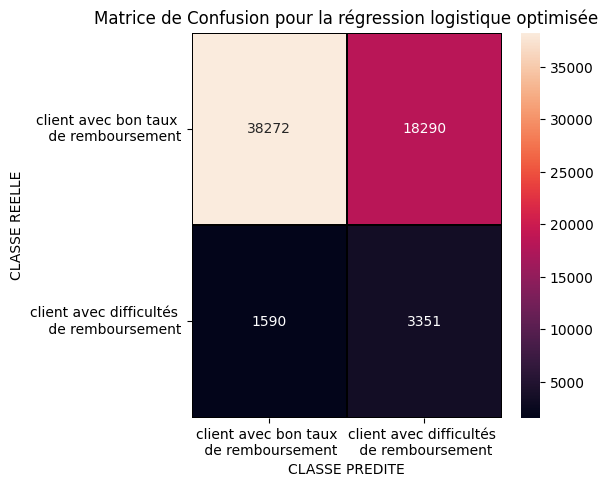

In [226]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_pred_lr_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique optimisée')
plt.show()

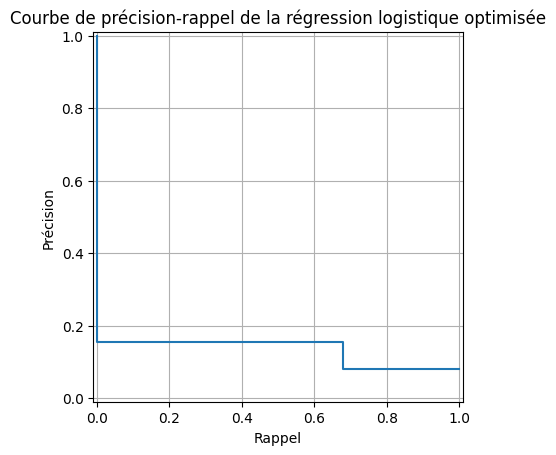

In [227]:
# Graphique précision-rappel
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr_gd)
disp_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
disp_lr.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique optimisée')

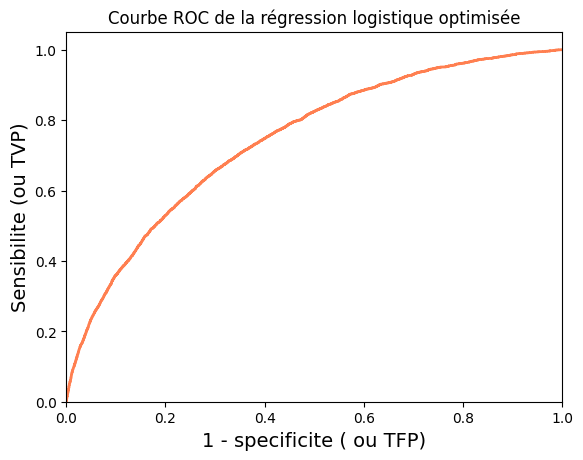

In [228]:
# Graphique courbe ROC
[fpr_lr, tpr_lr, thr_lr] = metrics.roc_curve(y_test, y_prob_lr_gd)
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique optimisée')

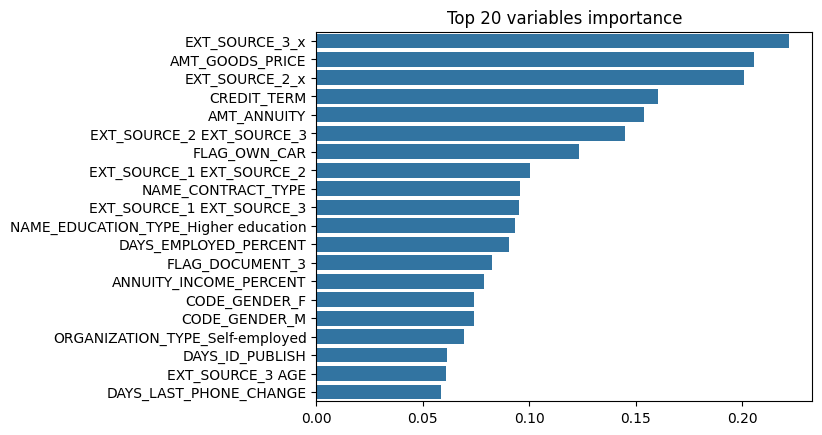

In [229]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_lr = (pd.Series(best_model_lr_gs.coef_[0],X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_lr, orient="y")
plt.title("Top 20 variables importance")
plt.show()

Nous pouvons voir que les données du feature engineering ont une importance élevée dans ce modèle optimisé de régression logistique.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [230]:
# F3 score selon les différents seuils de décision
f3_score_lr=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_lr_gd > i, 1, 0))
  f3_score_lr.append(str(fbeta_score(y_test,preds, beta=3)))


In [231]:
y_prob_lr_gd

array([0.17043602, 0.69096539, 0.14590424, ..., 0.4196634 , 0.22384941,
       0.58674231])

In [232]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_lr})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


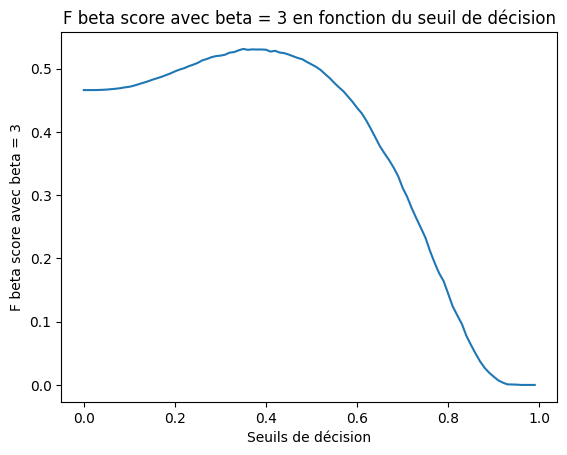

In [233]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [234]:
# Cherchons la valeur maximale du F3 score
f3_score_lr_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_lr=df.loc[df['f3_score']==f3_score_lr_max,['abs']]
seuil_opt_lr=seuil_opt_lr.values[0,0]
seuil_opt_lr

0.35

In [235]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_lr_opt=(y_prob_lr_gd> seuil_opt_lr).astype(int)

In [236]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_lr_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_lr_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_lr_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_lr_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_lr_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_lr_opt)))

Accuracy Score : 0.4609693836073037
Precision Score : 0.11724961332862996
Recall Score : 0.8745193280712407
F1 Score : 0.20677609226204718
F beta Score (avec beta=3) : 0.5313445316150611
Aire sous la courbe ROC : 0.6496814312998613


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,35.

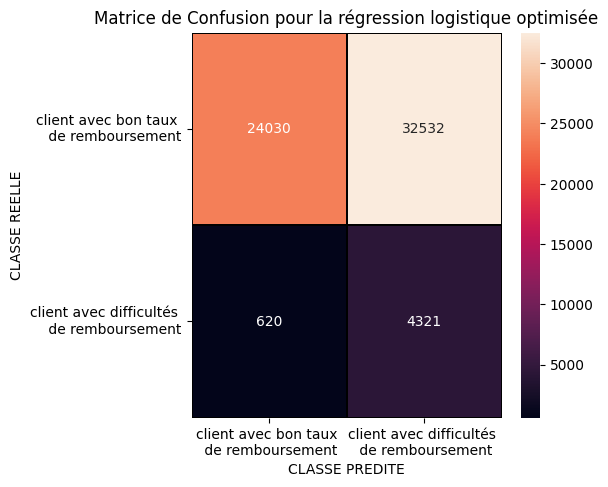

In [237]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_lr_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique optimisée')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions.

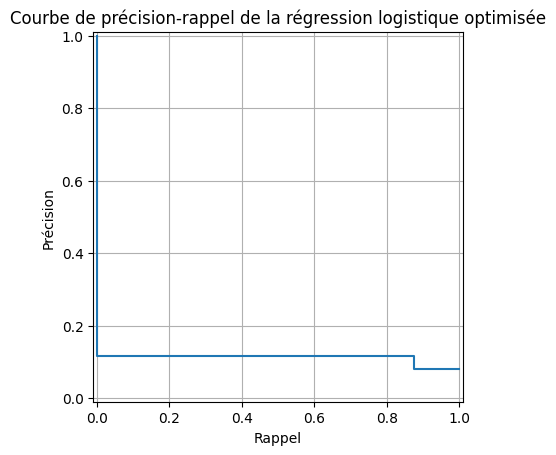

In [238]:
# Graphique précision-rappel
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_lr_opt)
disp_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
disp_lr.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique optimisée')

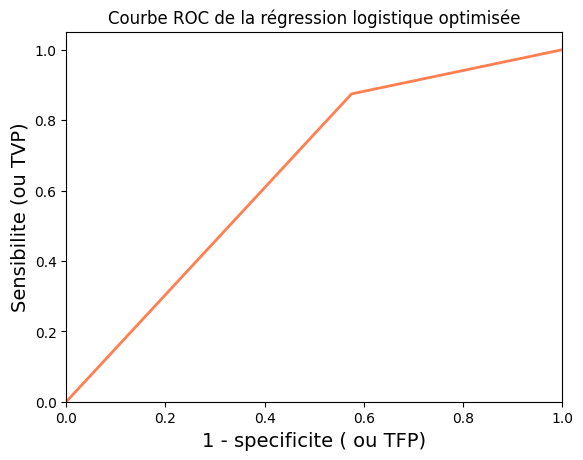

In [239]:
# Graphique courbe ROC
[fpr_lr, tpr_lr, thr_lr] = metrics.roc_curve(y_test, y_lr_opt)
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique optimisée')

### Modèles linéaires de Machines à Vecteurs de Support (SVM):

Ils ont pour but de séparer linéairement les données en classes à l’aide d’une frontière aussi « simple » que possible, de telle façon que la distance entre les différents groupes de données et la frontière qui les sépare soit maximale. Cette distance est aussi appelée « marge » et les SVMs sont ainsi qualifiés de « séparateurs à vaste marge », les « vecteurs de support » étant les données les plus proches de la frontière.

La version primale résout un problème d'optimisation à p variables et est donc préférable si on a moins de variables que d'échantillons, et inversement pour la version duale.

In [240]:
# Création d'une instance de modèle de SVM de classification
svm = LinearSVC(dual='auto', tol=1e-5,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
svm.fit(X_train_eq,y_train_eq)
y_pred_svm = svm.predict(X_test_norm)



In [241]:
# score de la SVM
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm)))

Accuracy Score : 0.6914459457262248
Precision Score : 0.15988174857032084
Recall Score : 0.667678607569318
F1 Score : 0.2579863147605083
F beta Score (avec beta=3) : 0.5067354806998141
Aire sous la courbe ROC : 0.6806003801256653


In [242]:
svm = LinearSVC(dual='auto', tol=1e-5,max_iter=200,random_state=42)
params={"C": np.logspace(-5, 5, 10),"penalty":['l1','l2']}

# optimisation des paramètres avec la grid search
grid_svm = GridSearchCV(svm, params,cv=3, n_jobs=-1)
grid_svm.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_gs = grid_svm.best_estimator_

In [243]:
print(best_model_svm_gs)

LinearSVC(C=0.2782559402207126, dual='auto', max_iter=200, random_state=42,
          tol=1e-05)


In [244]:
cvres_svm=pd.DataFrame(grid_svm.cv_results_)
cvres_svm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.561049,0.102008,0.050399,0.001830,0.00001,l1,"{'C': 1e-05, 'penalty': 'l1'}",0.500000,0.500000,0.500000,0.500000,0.000000,20
1,2.233289,0.143339,0.058498,0.009529,0.00001,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.667170,0.674940,0.663398,0.668502,0.004805,18
2,0.823690,0.104542,0.055793,0.010632,0.000129,l1,"{'C': 0.0001291549665014884, 'penalty': 'l1'}",0.644312,0.645368,0.640842,0.643507,0.001933,19
3,5.343875,0.553583,0.084482,0.001919,0.000129,l2,"{'C': 0.0001291549665014884, 'penalty': 'l2'}",0.676599,0.684822,0.677278,0.679566,0.003727,16
4,6.804685,0.310161,0.095918,0.008911,0.001668,l1,"{'C': 0.0016681005372000592, 'penalty': 'l1'}",0.676675,0.682936,0.673355,0.677655,0.003972,17
5,21.906213,1.480603,0.097551,0.019971,0.001668,l2,"{'C': 0.0016681005372000592, 'penalty': 'l2'}",0.681126,0.686029,0.677127,0.681427,0.003640,14
6,23.389030,1.786484,0.126660,0.003891,0.021544,l1,"{'C': 0.021544346900318846, 'penalty': 'l1'}",0.680220,0.685199,0.677580,0.681000,0.003159,15
7,263.883461,3.322138,0.136777,0.044340,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.683011,0.687915,0.678033,0.682986,0.004034,7
8,31.088935,4.024549,0.145736,0.049411,0.278256,l1,"{'C': 0.2782559402207126, 'penalty': 'l1'}",0.681201,0.687462,0.679541,0.682735,0.003411,12
9,412.154331,86.871361,0.087549,0.011631,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.683087,0.687915,0.679843,0.683615,0.003316,1


In [245]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_score")
cvres_svm.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,mean_test_score,std_test_score,rank_test_score
9,412.154331,86.871361,0.087549,0.011631,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.683615,0.003316,1
13,203.281488,32.131022,0.107390,0.020380,46.415888,l2,"{'C': 46.41588833612782, 'penalty': 'l2'}",0.683565,0.003288,2
17,197.879599,31.290386,0.061034,0.019000,7742.636827,l2,"{'C': 7742.636826811277, 'penalty': 'l2'}",0.683540,0.003353,3
15,209.918296,45.537648,0.084523,0.037927,599.48425,l2,"{'C': 599.4842503189421, 'penalty': 'l2'}",0.683540,0.003353,3
19,154.570502,10.689253,0.063422,0.016730,100000.0,l2,"{'C': 100000.0, 'penalty': 'l2'}",0.683540,0.003353,3
11,326.965077,123.862619,0.119253,0.041480,3.593814,l2,"{'C': 3.593813663804626, 'penalty': 'l2'}",0.683389,0.003428,6
7,263.883461,3.322138,0.136777,0.044340,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.682986,0.004034,7
12,34.097512,2.724445,0.110192,0.015161,46.415888,l1,"{'C': 46.41588833612782, 'penalty': 'l1'}",0.682810,0.003582,8
18,33.920960,1.224791,0.149246,0.018091,100000.0,l1,"{'C': 100000.0, 'penalty': 'l1'}",0.682760,0.003468,9
14,42.110471,2.045691,0.150075,0.020071,599.48425,l1,"{'C': 599.4842503189421, 'penalty': 'l1'}",0.682760,0.003468,9


Les hyperparamètres optimisés correspondent au couple {'C': 0.278256, 'penalty': 'l2'} et entrainent une maximisation du mean_test_score égal à 0.683615.

Cependant, la cinquième configuration  {'C': 100000.0	, 'penalty': 'l2'} a des résultats comparables pour un temps d'entrainement très inférieur.

Passons à la prédiction avec ce modèle optimisée :

In [246]:
# prédiction sur les meilleurs hyperparamètres
y_pred_svm_gd = best_model_svm_gs.predict(X_test_norm)

In [247]:
# score de la SVM avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm_gd)))

Accuracy Score : 0.6910882395980684
Precision Score : 0.15984320557491288
Recall Score : 0.668488160291439
F1 Score : 0.2579964850615114
F beta Score (avec beta=3) : 0.5071162083736355
Aire sous la courbe ROC : 0.6807753202008802


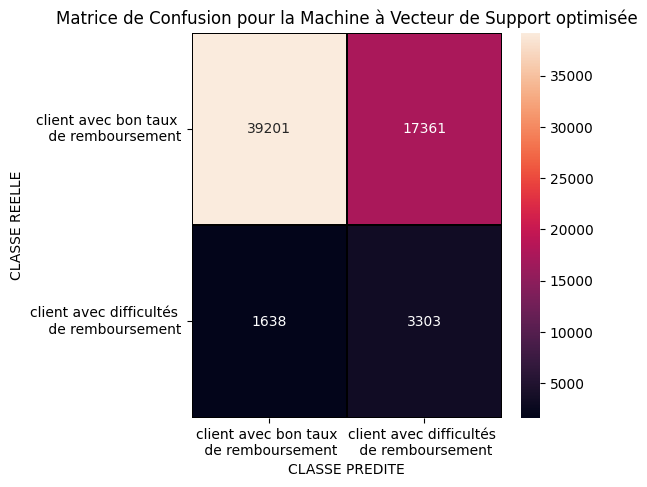

In [248]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la Machine à Vecteur de Support optimisée')
plt.show()

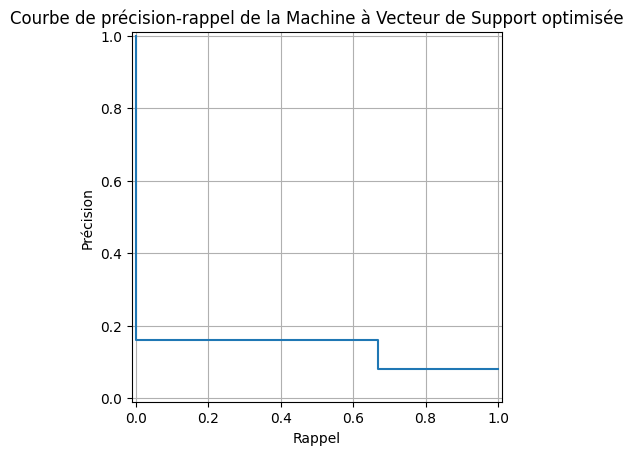

In [249]:
# Graphique précision-rappel
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm_gd)
disp_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm)
disp_svm.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la Machine à Vecteur de Support optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la Machine à Vecteur de Support optimisée')

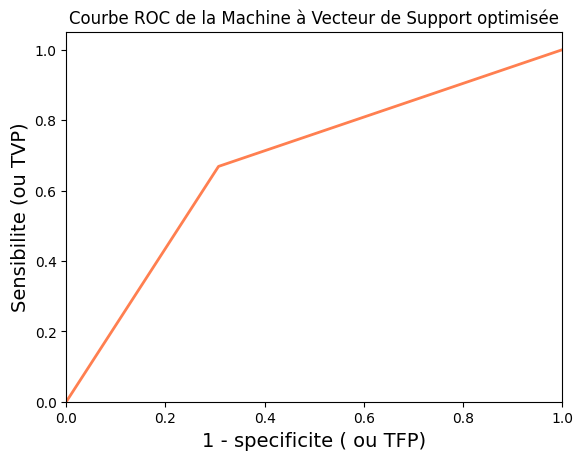

In [250]:
# Graphique courbe ROC
[fpr_svm, tpr_svm, thr_svm] = metrics.roc_curve(y_test, y_pred_svm_gd)
plt.plot(fpr_svm, tpr_svm, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la Machine à Vecteur de Support optimisée')

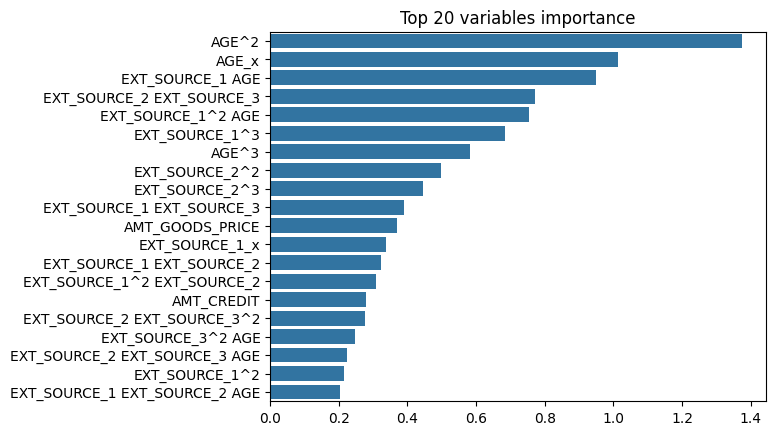

In [251]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_svm = (pd.Series(best_model_svm_gs.coef_[0],X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_svm, orient="y")
plt.title("Top 20 variables importance")
plt.show()

Nous pouvons voir que les données liées à l'âge et aux EXT_SOURCE ont une importance élevée dans ce modèle optimisé de SVM.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [252]:
clf = CalibratedClassifierCV(svm)
clf.fit(X_train_eq,y_train_eq)
y_proba_svm_gd = clf.predict_proba(X_test_norm)[:, 1]

In [253]:
y_proba_svm_gd

array([0.19736377, 0.6821715 , 0.16968123, ..., 0.37188191, 0.2693834 ,
       0.61494263])

In [254]:
# F3 score selon les différents seuils de décision
f3_score_svm=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_proba_svm_gd > i, 1, 0))
  f3_score_svm.append(str(fbeta_score(y_test,preds, beta=3)))


In [255]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_svm})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


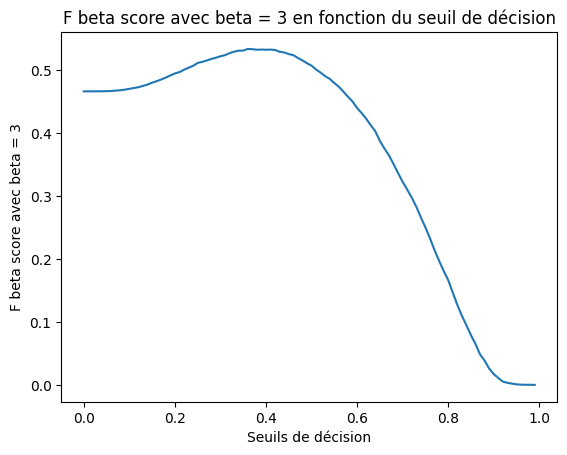

In [256]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [257]:
# Cherchons la valeur maximale du F3 score
f3_score_svm_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_svm=df.loc[df['f3_score']==f3_score_svm_max,['abs']]
seuil_opt_svm=seuil_opt_svm.values[0,0]
seuil_opt_svm

0.36

In [258]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_svm_opt=(y_proba_svm_gd> seuil_opt_svm).astype(int)

In [259]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_svm_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_svm_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_svm_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_svm_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_svm_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_svm_opt)))

Accuracy Score : 0.4921873729736761
Precision Score : 0.12165779248812779
Recall Score : 0.8554948391013965
F1 Score : 0.2130222244620269
F beta Score (avec beta=3) : 0.5336177948342464
Aire sous la courbe ROC : 0.6579726591108269


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,36.

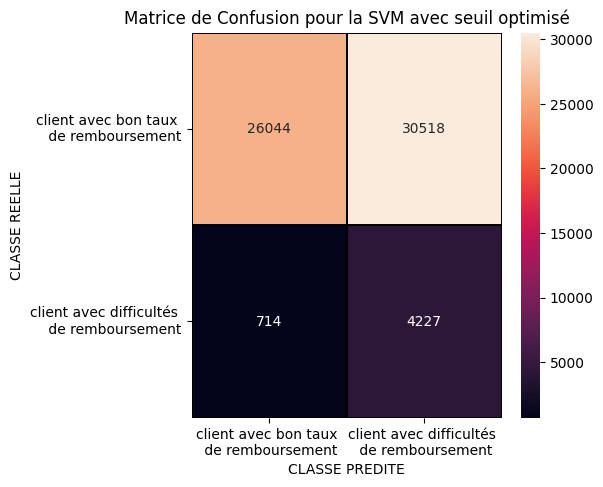

In [260]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_svm_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM avec seuil optimisé')
plt.show()

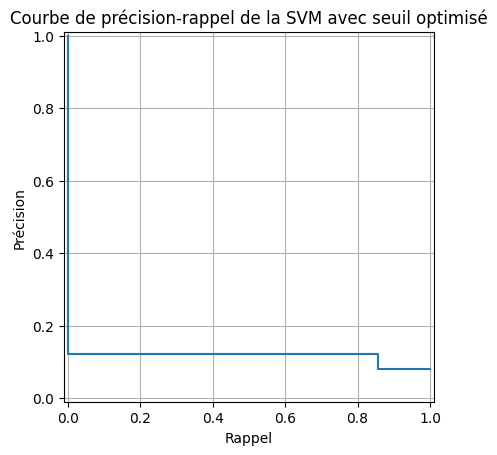

In [261]:
# Graphique précision-rappel
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_svm_opt)
disp_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm)
disp_svm.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM avec seuil optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM avec seuil optimisé')

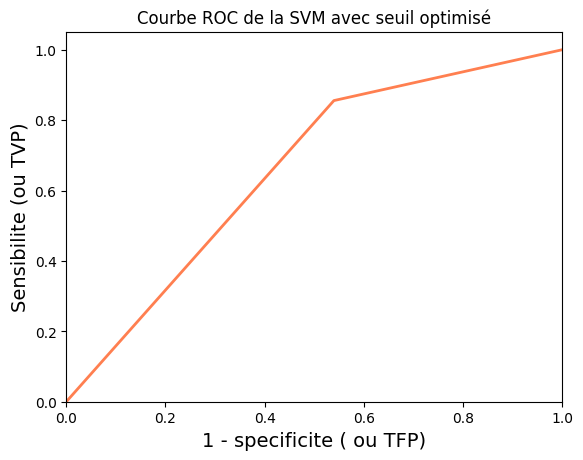

In [262]:
# Graphique courbe ROC
[fpr_svm, tpr_svm, thr_svm] = metrics.roc_curve(y_test, y_svm_opt)
plt.plot(fpr_svm, tpr_svm, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM avec seuil optimisé')


### Modèles non-linéaires de SVM à noyau:

 Afin de remédier au problème de l'absence de séparateur linéaire, on utilise un noyau (en anglais kernel) pour déplacer le problème dans un espace de dimension supérieure, éventuellement de dimension infinie.

 Dans ce nouvel espace, appelé espace de redescription, il est alors probable qu'il existe une séparation linéaire.

La fonction noyau choisie doit respecter certaines conditions : être symétrique et semi-définie positive. Cela peut être une fonction noyau polynômial ou exponentielle, ou gaussien(RBF),...

In [263]:
# Création d'une instance de modèle de SVM de classification à noyau
svm_noy = SVC(tol=1e-5,max_iter=200,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
svm_noy.fit(X_train_eq,y_train_eq)
y_pred_svm_noy = svm_noy.predict(X_test_norm)

In [264]:
# score de la SVM à noyau
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_noy)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_noy)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_noy)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_noy)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_noy, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm_noy)))

Accuracy Score : 0.5965725249174837
Precision Score : 0.09890597876549191
Recall Score : 0.49585104229912974
F1 Score : 0.1649165320409262
F beta Score (avec beta=3) : 0.353841709994223
Aire sous la courbe ROC : 0.5506110697510995


In [265]:
svm_noy = SVC( tol=1e-5,max_iter=200,random_state=42)
params={"C": np.logspace(-5, 5, 10),"kernel":['poly', 'rbf', 'sigmoid'],"gamma": ["scale", "auto"]}

# optimisation des paramètres avec la grid search
grid_svm_noy = GridSearchCV(svm_noy, params,cv=3, n_jobs=-1)
grid_svm_noy.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_noy_gs = grid_svm_noy.best_estimator_

In [267]:
print(best_model_svm_noy_gs)

SVC(C=0.021544346900318846, gamma='auto', max_iter=200, random_state=42,
    tol=1e-05)


In [268]:
cvres_svm_noy=pd.DataFrame(grid_svm.cv_results_)
cvres_svm_noy

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.561049,0.102008,0.050399,0.001830,0.00001,l1,"{'C': 1e-05, 'penalty': 'l1'}",0.500000,0.500000,0.500000,0.500000,0.000000,20
1,2.233289,0.143339,0.058498,0.009529,0.00001,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.667170,0.674940,0.663398,0.668502,0.004805,18
2,0.823690,0.104542,0.055793,0.010632,0.000129,l1,"{'C': 0.0001291549665014884, 'penalty': 'l1'}",0.644312,0.645368,0.640842,0.643507,0.001933,19
3,5.343875,0.553583,0.084482,0.001919,0.000129,l2,"{'C': 0.0001291549665014884, 'penalty': 'l2'}",0.676599,0.684822,0.677278,0.679566,0.003727,16
4,6.804685,0.310161,0.095918,0.008911,0.001668,l1,"{'C': 0.0016681005372000592, 'penalty': 'l1'}",0.676675,0.682936,0.673355,0.677655,0.003972,17
5,21.906213,1.480603,0.097551,0.019971,0.001668,l2,"{'C': 0.0016681005372000592, 'penalty': 'l2'}",0.681126,0.686029,0.677127,0.681427,0.003640,14
6,23.389030,1.786484,0.126660,0.003891,0.021544,l1,"{'C': 0.021544346900318846, 'penalty': 'l1'}",0.680220,0.685199,0.677580,0.681000,0.003159,15
7,263.883461,3.322138,0.136777,0.044340,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.683011,0.687915,0.678033,0.682986,0.004034,7
8,31.088935,4.024549,0.145736,0.049411,0.278256,l1,"{'C': 0.2782559402207126, 'penalty': 'l1'}",0.681201,0.687462,0.679541,0.682735,0.003411,12
9,412.154331,86.871361,0.087549,0.011631,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.683087,0.687915,0.679843,0.683615,0.003316,1


In [269]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_score")
cvres_svm_noy.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,mean_test_score,std_test_score,rank_test_score
9,412.154331,86.871361,0.087549,0.011631,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.683615,0.003316,1
13,203.281488,32.131022,0.107390,0.020380,46.415888,l2,"{'C': 46.41588833612782, 'penalty': 'l2'}",0.683565,0.003288,2
17,197.879599,31.290386,0.061034,0.019000,7742.636827,l2,"{'C': 7742.636826811277, 'penalty': 'l2'}",0.683540,0.003353,3
15,209.918296,45.537648,0.084523,0.037927,599.48425,l2,"{'C': 599.4842503189421, 'penalty': 'l2'}",0.683540,0.003353,3
19,154.570502,10.689253,0.063422,0.016730,100000.0,l2,"{'C': 100000.0, 'penalty': 'l2'}",0.683540,0.003353,3
11,326.965077,123.862619,0.119253,0.041480,3.593814,l2,"{'C': 3.593813663804626, 'penalty': 'l2'}",0.683389,0.003428,6
7,263.883461,3.322138,0.136777,0.044340,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.682986,0.004034,7
12,34.097512,2.724445,0.110192,0.015161,46.415888,l1,"{'C': 46.41588833612782, 'penalty': 'l1'}",0.682810,0.003582,8
18,33.920960,1.224791,0.149246,0.018091,100000.0,l1,"{'C': 100000.0, 'penalty': 'l1'}",0.682760,0.003468,9
14,42.110471,2.045691,0.150075,0.020071,599.48425,l1,"{'C': 599.4842503189421, 'penalty': 'l1'}",0.682760,0.003468,9


Les hyperparamètres optimisés correspondent au couple {'C': 0.278256, 'penalty': 'l2'} et entrainent une maximisation du mean_test_score égal à 0.683615.

Cependant, la cinquième configuration {'C': 100000.0 , 'penalty': 'l2'} a des résultats comparables pour un temps d'entrainement très inférieur.

Passons à la prédiction avec ce modèle optimisée :

In [270]:
# prédiction sur les meilleurs hyperparamètres
y_pred_svm_noy_gd = best_model_svm_noy_gs.predict(X_test_norm)

In [271]:
# score de la SVM à noyau avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_noy_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_noy_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_noy_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_noy_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_noy_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm_noy_gd)))

Accuracy Score : 0.6211404321740402
Precision Score : 0.10912884271480883
Recall Score : 0.5187209066990488
F1 Score : 0.1803215253104443
F beta Score (avec beta=3) : 0.3771613567802222
Aire sous la courbe ROC : 0.5744041222438351


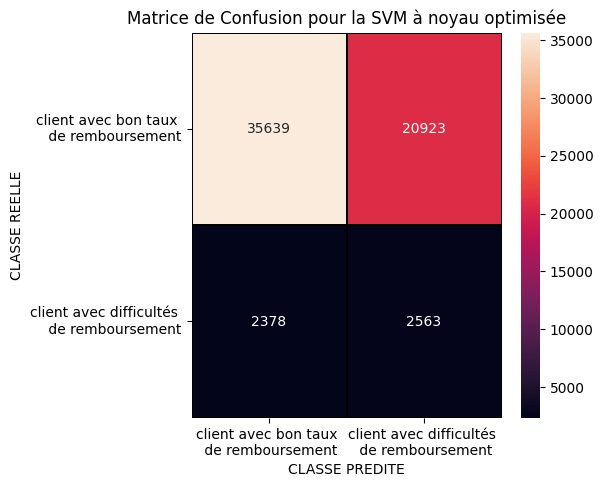

In [272]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm_noy_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau optimisée')
plt.show()

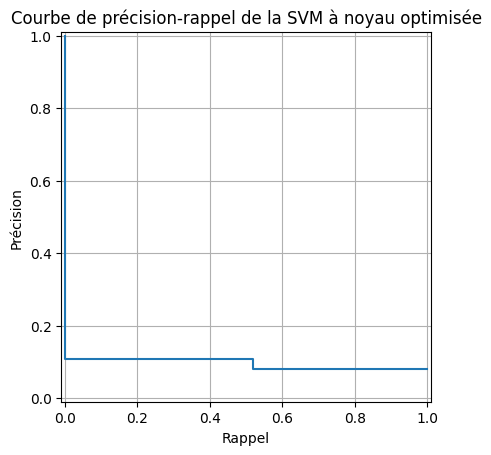

In [273]:
# Graphique précision-rappel
precision_svm_noy, recall_svm_noy, _ = precision_recall_curve(y_test, y_pred_svm_noy_gd)
disp_svm_noy = PrecisionRecallDisplay(precision=precision_svm_noy, recall=recall_svm_noy)
disp_svm_noy.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM à noyau optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM à noyau optimisée')

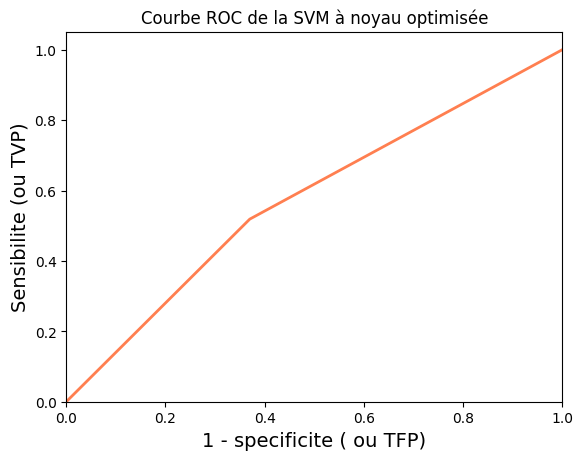

In [274]:
# Graphique courbe ROC
[fpr_svm_noy, tpr_svm_noy, thr_svm_noy] = metrics.roc_curve(y_test, y_pred_svm_noy_gd)
plt.plot(fpr_svm_noy, tpr_svm_noy, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM à noyau optimisée')

In [285]:

# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_svm_noy = (pd.Series(best_model_svm_noy_gs.dual_coef_[0:support_indices[0]],X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_svm_noy, orient="y")
plt.title("Top 20 variables importance")
plt.show()

ValueError: Length of values (1) does not match length of index (276)

In [290]:
best_model_svm_noy_gs.dual_coef_.shape

(1, 400)

In [280]:
best_model_svm_gs.coef_[0].shape

(276,)

In [284]:
best_model_svm_noy_gs.dual_coef_[0].shape

(400,)

In [291]:
X_train_eq.shape

(39768, 276)

**Ressources :**


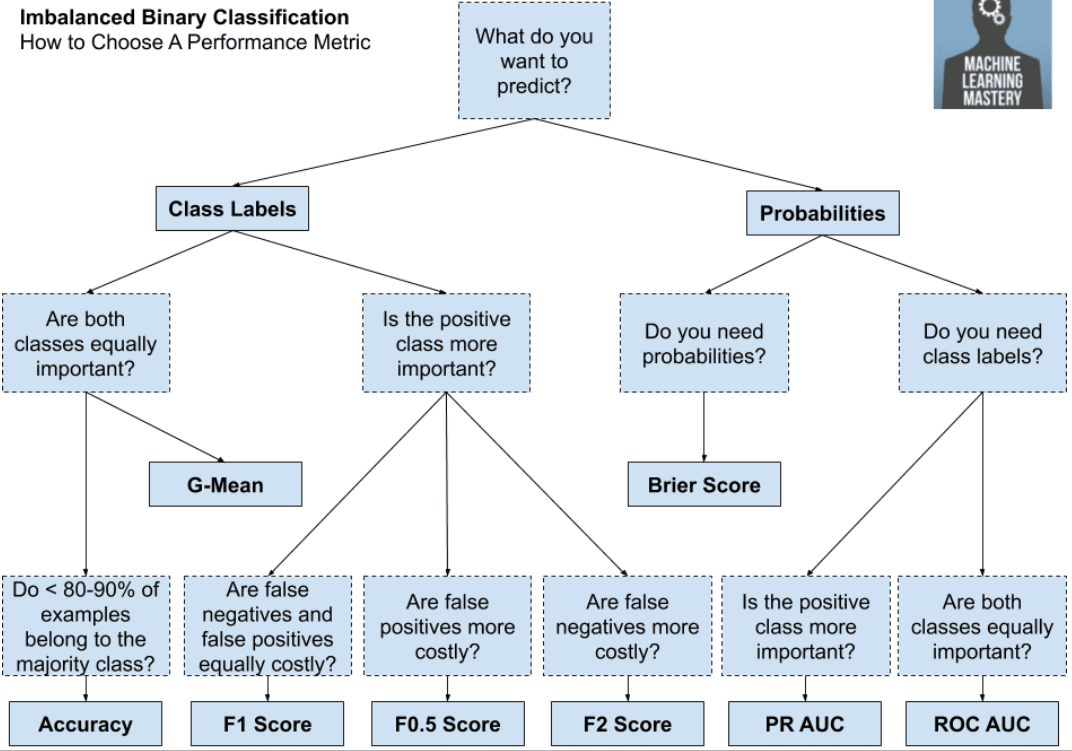

In [266]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', DummyClassifier())
])

grid = GridSearchCV(estimator=pipe,
                    param_grid={'model__strategy': ['stratified', 'most_frequent', 'uniform']},
                    cv=5,
                    scoring={'acc': make_scorer(accuracy_score)},
                    refit='acc',
                    return_train_score=True)

grid.fit(X, y)
pd.DataFrame(grid.cv_results_)[['param_model__strategy', 'mean_test_acc']]


NameError: name 'Pipeline' is not defined

In [ ]:
lr = LogisticRegression(solver='sag', max_iter=100)
params = {'C': np.logspace(-3, 3, 7), 'penalty':['l2']}

model_lr_gs = GridSearchCV(lr, params, cv=3, n_jobs=-1,
                scoring='roc_auc')

model_lr_gs.fit(X_train_scale, y_train)
best_model_lr_gs = model_lr_gs.best_estimator_


Afin d'améliorer la qualité du modèle et minimiser le biais de sélection du jeu d'entraînement, nous allons utiliser la méthode StratifiedKFold() qui permet de "mixer" les résultats sur plusieurs sous-ensembles du jeu d'entraînement.

Afin de chercher les meilleurs hyper-paramètres de chacun des modèles, nous allons utiliser la recherche HalvingRandomSearchCV() qui permet d'éliminer des combinaisons d'hyper-paramètres en plusieurs étapes, et d'optimiser les ressources allouées à chaque étape.

In [ ]:
# approche naive
DummyClassifier  du module  dummy  de scikit-learn


# exemple OCR

from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


# La meilleure performance (~0.757) est ici atteinte avec 7 voisins.

# Nous pouvons maintenant regarder la performance sur le jeu de test. GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement,

y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))


In [ ]:
# courbe ROC d'un KNN
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

# aire sous la courbe ROC
print(metrics.auc(fpr, tpr))


Le taux de faux négatif est de un moins la sensibilité(TVP).
Pour une spécificité (TFP) supérieure à 0.8, la sensibilité (TVP) est supérieure à 0.95 et donc le taux de faux négatif doit être inférieure à 1 - 0.95 = 0.0.5.

Le taux de faux négatif est de un moins le recall(TVP). Donc pour une précision de 0.4, on a 0.4 de recall(TVP) soit 0.6 de taux de faux négatif.

si la classe présente majoritairement dans le dataset est négative. La F-mesure du classifieur naïf  "most_frequent" est alors de zéro puisqu'il a un taux de VP = 0.